In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
df = pd.read_csv("HCM_weather_42023_42024.csv")
dftest = pd.read_csv('HCM_weather_42023_42024_test.csv')

In [15]:
# data['Humidity'].plot(kind='hist')
# plt.figure(figsize=(10, 8))
# data['Visibility (km)'].plot(kind='hist')

# for column in data.columns:
#     plt.figure(figsize=(8, 6))
#     data[column].value_counts().plot(kind = 'hist')


In [16]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

# Trích xuất các thành phần từ cột datetime
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

In [17]:
features = df[['feelslike', 'dew', 'humidity', 'windgust', 'winddir', 'solarradiation', 'visibility', 'cloudcover', 'month', 'hour']]
labels = df['temp']

In [18]:
X_train, y_train =features.values, labels.values
X_train.shape, y_train.shape

((9504, 10), (9504,))

In [19]:
scalers = {}
features_ = ['feelslike', 'dew', 'humidity', 'windgust', 'winddir', 'solarradiation', 'visibility', 'cloudcover', 'month', 'day']
for i, feature in enumerate(features_):
    #scalers[feature] = MinMaxScaler(feature_range=(0, 1))
    scalers[feature] = StandardScaler()
    X_train[:, i] = scalers[feature].fit_transform(X_train[:,i].reshape(-1, 1)).reshape(-1)


In [ ]:
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_ = X[i:i+seq_length]
        y_ = y[i+seq_length]  # Dự đoán 1 lần nhiệt độ
        xs.append(x_)
        ys.append(y_)
    return np.array(xs), np.array(ys)

seq_length = 20 # Sử dụng 20 giờ để dự đoán giờ tiếp theo (nên đổi thành 24)
X_seq, y_seq = create_sequences(X_train, y_train, seq_length)

In [21]:
X_train = torch.tensor(X_seq, dtype=torch.float32)
y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1) 

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [24]:
X_train=X_train.to(device)
print(X_train.shape)
y_train=y_train.to(device)
class WeatherLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size=512, output_size=1, n_layers=1):
        super(WeatherLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, 1, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
        ce0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
        out, (h0, ce0) = self.lstm(input_seq, (h0, ce0))
        # số cụm, 24, 9
        out = self.linear(out[:, -1, :])
        
        return out

input_size = len(features_)
model = WeatherLSTM(input_size).to(device)
#______________________________________________________________
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
# cost = np.array([])
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


torch.Size([9484, 20, 10])


In [31]:
torch.save(model, 'modelLSTM.pth')

In [25]:
# modelx = WeatherLSTM(input_size, hidden_layer_size=512, output_size=1, n_layers=1)

# modelx = torch.load('modelLSTM.pth')

In [26]:
dftest['datetime'] = pd.to_datetime(dftest['datetime'], utc=True)

# Trích xuất các thành phần từ cột datetime
dftest['month'] = dftest['datetime'].dt.month
dftest['hour'] = dftest['datetime'].dt.hour
features_test = dftest[['feelslike', 'dew', 'humidity', 'windgust', 'winddir', 'solarradiation', 'visibility', 'cloudcover', 'month', 'hour']]
labels_test = dftest['temp']
X_test, y_test =features_test.values, labels_test.values


In [27]:

for i, feature in enumerate(features_):
    X_test[:, i] = scalers[feature].transform(X_test[:,i].reshape(-1, 1)).reshape(-1)

In [28]:
X_seq_test, y_seq_test = create_sequences(X_test, y_test, seq_length)

In [29]:
X_test_t = torch.tensor(X_seq_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_seq_test, dtype=torch.float32).unsqueeze(1).to(device)

In [32]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_t)
predictions = predictions.cpu()
print('accuracy: ', mean_absolute_error(y_test_t.cpu(), predictions))


accuracy:  0.6714883


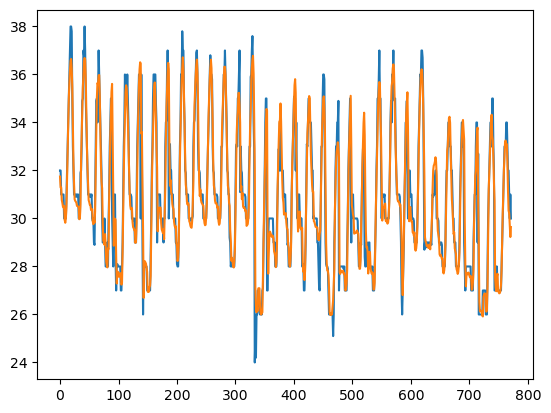

In [34]:

plt.plot(np.arange(772), y_test_t.cpu())
plt.plot(np.arange(772), predictions.cpu())
plt.show()

In [1]:
!jupyter nbconvert --to script LSTM_Timesr_Weather.ipynb

[NbConvertApp] Converting notebook LSTM_Timesr_Weather.ipynb to script
[NbConvertApp] Writing 4877 bytes to LSTM_Timesr_Weather.py
